In [10]:
import torch 
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

from  torchsummary import summary

from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import numpy as np
import os

In [11]:
USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda' if USE_CUDA else "cpu")

print(device)

cuda


In [12]:
# 변수 설정
BATCH_SIZE = 32
EPOCH = 10
NUM_CLASS = 121
BATCH_MOMENTM = 0.9
learning_rate = 0.001

# 물체 개수
NUM_OBKECT = 2          # 추정할 물체 개수
TOLERANCE_ANGLE = 2     # 허용 오차 각도

# 학습 여부
TRAIN_CHOICE = True

# 이전 모델 불러오기
checkpoint = None
# checkpoint = torch.load('./models/model_origin_target_2.ckpt')

### 데이터 불러오기

In [13]:
## 물체 2개

if NUM_OBKECT == 1:
    Rx_sig = np.load('../data/target_1/total_output_COV_1.npy')
    angle  = np.load('../data/target_1/total_output_angle_1.npy')

    train_size = round(Rx_sig.shape[0]*0.8)
    print(f'train size: {train_size}')
    
elif NUM_OBKECT == 2:
    Rx_sig = np.load(f'../data/target_2/output_COV_2(0).npy')
    angle  = np.load(f'../data/target_2/output_angle_array_2(0).npy')

    for idx in range(1, 71):
        Rx_sig_tmp = np.load(f'../data/target_2/output_COV_2({idx}).npy')
        angle_tmp  = np.load(f'../data/target_2/output_angle_array_2({idx}).npy')

        Rx_sig = np.concatenate((Rx_sig, Rx_sig_tmp))
        angle = np.concatenate((angle, angle_tmp))

    print(Rx_sig.shape)
    print(angle.shape)

    train_size = round(Rx_sig.shape[0]*0.8)
    print(f'train size: {train_size}')

(10000, 4, 4)
(10000, 121)
train size: 8000


In [14]:
# import train data
x_train = np.array([[np.real(Rxx), np.imag(Rxx), np.angle(Rxx)] for Rxx in Rx_sig[:train_size]])
y_train = angle[:train_size]

# import valid data
x_valid = np.array([[np.real(Rxx), np.imag(Rxx), np.angle(Rxx)] for Rxx in Rx_sig[train_size:]])
y_valid = angle[train_size:]

# import test data
x_test = np.array([[np.real(Rxx), np.imag(Rxx), np.angle(Rxx)] for Rxx in Rx_sig[train_size:]])
y_test = angle[train_size:]

# y_test size transition
test_size = len(y_test)                     # 총 크기
find_num = len(np.where(y_test[0]== 1)[0])  # 찾아야 하는 물체의 개수

y_test_tmp = np.zeros((y_test.shape[0], find_num))
for idx, data in enumerate(y_test):
  
    y_test_tmp[idx] = np.where(data== 1)[0]

y_test = y_test_tmp

class MyDataset(Dataset):
  def __init__(self, data, label):
    self.data = torch.Tensor(data).type(torch.float)
    self.label = torch.Tensor(label)

  def __len__(self, ):
    return self.data.shape[0]

  def __getitem__(self, index):
    return self.data[index], self.label[index]

In [15]:
train_set = MyDataset(x_train, y_train)
valid_set = MyDataset(x_valid, y_valid)
test_set = MyDataset(x_test, y_test)

train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle = True)
valid_loader = DataLoader(dataset=valid_set, batch_size=BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle = True)

In [16]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
    
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=BATCH_MOMENTM),
            nn.ReLU())
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=BATCH_MOMENTM),
            nn.ReLU())
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=BATCH_MOMENTM),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=BATCH_MOMENTM),
            nn.ReLU())
        
        self.fc1 = nn.Sequential(
            nn.Linear(4*4*256, 4096),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
                
        self.fc3 = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        self.fc4 = nn.Sequential(
            nn.Linear(1024, NUM_CLASS),
            nn.Sigmoid()   # 이렇게 바꾸면 Binary Cross entropy를 못쓴다.
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        
        return out
    

In [17]:
# 모델 직접 저장 예시
model = ConvNet().to(device)

if checkpoint:
    model.load_state_dict(checkpoint)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=[0.9, 0.999])

In [18]:
if TRAIN_CHOICE is True:
    # Train the model
    total_train_step = len(train_loader)
    total_valid_step = len(valid_loader)

    total_train_loss, total_valid_loss = [], []
    for epoch in range(EPOCH):
        train_loss, val_loss = 0, 0
        train_tqdm = tqdm(train_loader, total=len(train_loader), leave=False)
        
        model.train()
        for i, (x_train, y_train) in enumerate(train_tqdm, 1):
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            
            # Forward pass
            outputs = model(x_train)
            loss = criterion(outputs, y_train)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            
            train_tqdm.set_description(desc=f'Training Loss on Epoch [{epoch+1}/{EPOCH}]: {train_loss / i: .3f}')
            
        with torch.no_grad():
            for k, (x_valid, y_valid) in enumerate(valid_loader):  # data의 크기를 bath_size 만큼 나눈 것을 반복한다.
                x_valid = x_valid.to(device)
                y_valid = y_valid.to(device)
                
                val_output = model.forward(x_valid)
                v_loss = criterion(val_output, y_valid)
                val_loss += v_loss.item()
            
        total_train_loss.append(train_loss/total_train_step)
        total_valid_loss.append(val_loss/total_valid_step)
        
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
            .format(epoch+1, EPOCH, i, total_train_step, train_loss/total_train_step))

Epoch [1/1], Step [250/250], Loss: 0.0953


In [19]:
def mapping_val(pred, test):
    pred_list, test_list = list(pred), list(test)
    mapping_list = []
    
    for val_test in test_list:
        min_val = float('inf')
        
        for val_pred in pred_list:
            result = abs(val_test - val_pred)
            
            if result < min_val:
                min_val = result
                mapping_val = val_pred
                
        mapping_list.append(abs(val_test - mapping_val))
        pred_list.remove(mapping_val)
    
    return mapping_list

# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct, total = 0, 0

    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test
        outputs = model(x_test)
        
        # 총 물체 개수
        total += y_test.size(0) * find_num
        
        # 찾아야 하는 물체의 index 추출
        results = map(lambda matrix: torch.topk(matrix, k=find_num, largest=True), outputs) 
        predicted = torch.tensor([list(map(lambda x: x.item(), indices)) for _, indices in results]) 
        
        # 추정 알고리즘
        result = np.array(list((map(mapping_val, predicted, y_test))))
        correct += (result <= TOLERANCE_ANGLE).sum()
 
    print('Test Accuracy of the model on the {} test images: {} %'.format(test_size, 100 * correct / total))
    
# Save the model checkpoint
if TRAIN_CHOICE is True:
    if not os.path.exists('./models/'):
        os.makedirs('./models/')
    torch.save(model.state_dict(), './models/model.ckpt')

Test Accuracy of the model on the 2000 test images: 16.95 %


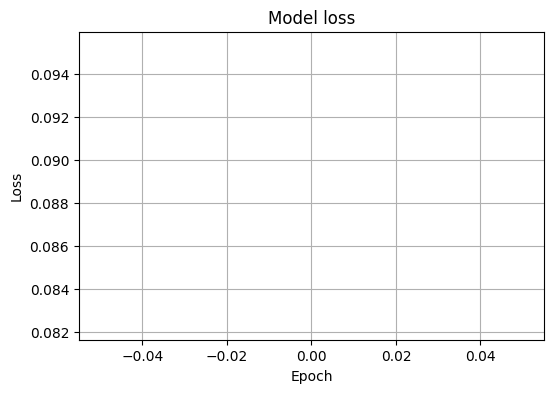

In [20]:
import matplotlib.pyplot as plt

## save fig
if TRAIN_CHOICE is True:
    plt.figure(figsize=(6, 4))
    plt.plot(list(range(EPOCH)), total_train_loss)
    plt.plot(list(range(EPOCH)), total_valid_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid()